In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 31.0 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Input, MaxPooling2D
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint
import plotly.express as px
from numpy import expand_dims
import cv2

In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/Kompjuterski vid/Projekat/dataset1/sign_mnist_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Kompjuterski vid/Projekat/dataset1/sign_mnist_test.csv")

In [5]:
test = pd.read_csv("/content/drive/MyDrive/Kompjuterski vid/Projekat/dataset1/sign_mnist_test.csv")
y = test['label']

In [6]:
labele = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']

In [7]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [8]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [9]:
x_train = train_df.values
x_test = test_df.values

In [10]:
x_train_rgb_pom = x_train.reshape(-1,28,28,1)
x_test_rgb_pom = x_test.reshape(-1,28,28,1)

images = tf.convert_to_tensor(x_train_rgb_pom, dtype=tf.uint8)
x_train = tf.image.grayscale_to_rgb(images,name=None)

images1 = tf.convert_to_tensor(x_test_rgb_pom, dtype=tf.uint8)
x_test = tf.image.grayscale_to_rgb(images1,name=None)


**Model**

In [11]:
HEIGHT = 28
WIDTH = 28
IMAGE_SHAPE_RGB = (HEIGHT,WIDTH,3)

In [12]:
input_img = Input(shape=IMAGE_SHAPE_RGB)
x = Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')(input_img)
x = BatchNormalization()(x)
x = MaxPool2D((2,2) , strides = 2 , padding = 'same')(x)
x = Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2,2) , strides = 2 , padding = 'same')(x)
x = Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2,2) , strides = 2 , padding = 'same')(x)
x = Flatten()(x)
x = Dense(units = 512 , activation = 'relu')(x)
x = Dropout(0.3)(x)
out = Dense(24 , activation = 'softmax')(x)

model = Model(inputs=input_img, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 75)        2100      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       200   

In [13]:
def plot_loss_accuracy(history):
  epochs = [i for i in range(20)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  fig.set_size_inches(16,9)
  
  ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")
  
  ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Training & Validation Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")
  plt.show()

**Augmentacija**

In [14]:
def show_augmented_images(original_image, datagen):
  image = expand_dims(original_image,0)
  it = datagen.flow(image, batch_size=1)  
  for i in range(1):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    aug_image = batch[0]
    plt.title("Aug")
    plt.imshow(aug_image)
    plt.axis("off")
  plt.show()

In [15]:
def visualize_data_gen(datagen,x_train,y_train,batch_size):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
      for i in range(3 * 7):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(X_batch[i])
      plt.show()
      break

In [16]:
x_test /= 255

**Augmentacija1**

In [17]:
datagen_x_train_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

datagen_x_train_aug.fit(x_train)

In [18]:
def show_augmented_images1(original_image, datagen):
  image = expand_dims(original_image,0)
  it = datagen.flow(image, batch_size=1)  
  for i in range(3):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    aug_image = batch[0]
    plt.title("Aug")
    plt.imshow(aug_image)
    plt.axis("off")
  plt.show()

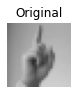

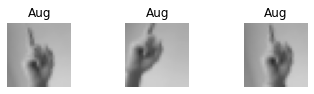

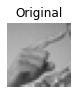

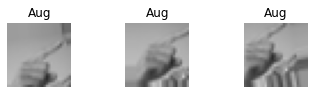

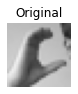

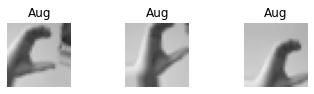

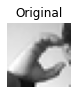

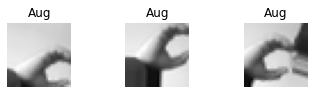

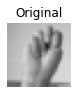

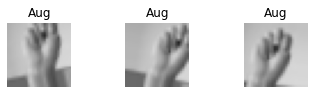

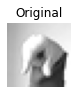

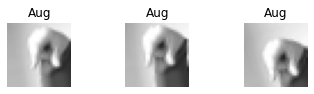

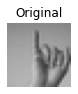

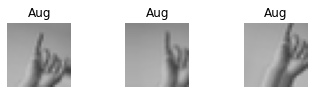

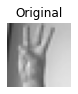

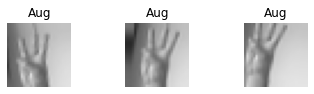

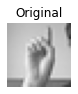

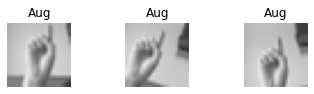

In [19]:
for i in range(9):
  plt.subplot(3,3,i+1)
  original_image = x_train[i]
  plt.title("Original")
  plt.axis("off")
  plt.imshow(original_image)
  plt.show()
  show_augmented_images1(original_image, datagen_x_train_aug)

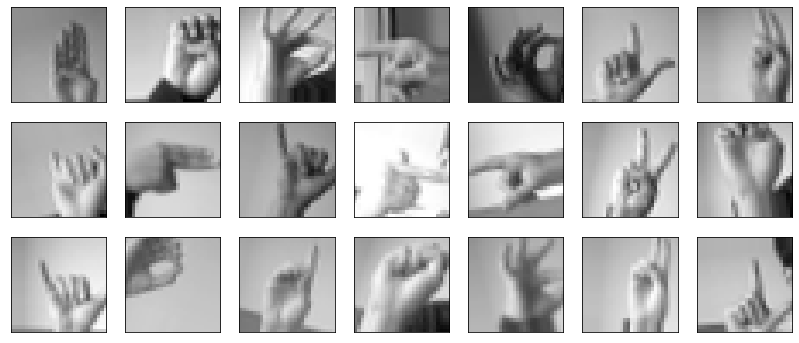

In [20]:
visualize_data_gen(datagen_x_train_aug,x_train,y_train,32)

In [21]:
path = '/content/drive/MyDrive/Kompjuterski vid/Projekat/Projekat_v4/Modeli_v4/model_rgb_aug1.hdf5'

save_callback = ModelCheckpoint(
  filepath=path,
  save_best_only=True,
  monitor="val_loss",
  verbose=1,
)

In [22]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy', tfa.metrics.F1Score(num_classes=24), tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [23]:
history = model.fit(datagen_x_train_aug.flow(x_train,y_train, batch_size = 32, subset='training'), 
                                  validation_data=datagen_x_train_aug.flow(x_train,y_train, batch_size = 8, subset='validation'), 
                                  epochs=20, verbose=1, callbacks=[save_callback])

Epoch 1/20
685/687 [============================>.] - ETA: 0s - loss: 1.4214 - accuracy: 0.5516 - f1_score: 0.5481 - precision: 0.7748 - recall: 0.4066
Epoch 1: val_loss improved from inf to 1.40470, saving model to /content/drive/MyDrive/Kompjuterski vid/Projekat/Projekat_v4/Modeli_v4/model_rgb_aug1.hdf5
687/687 [==============================] - 42s 44ms/step - loss: 1.4185 - accuracy: 0.5523 - f1_score: 0.5488 - precision: 0.7753 - recall: 0.4077 - val_loss: 1.4047 - val_accuracy: 0.5422 - val_f1_score: 0.5324 - val_precision: 0.6827 - val_recall: 0.4365
Epoch 2/20
687/687 [==============================] - ETA: 0s - loss: 0.4335 - accuracy: 0.8495 - f1_score: 0.8479 - precision: 0.8883 - recall: 0.8146
Epoch 2: val_loss improved from 1.40470 to 0.40750, saving model to /content/drive/MyDrive/Kompjuterski vid/Projekat/Projekat_v4/Modeli_v4/model_rgb_aug1.hdf5
687/687 [==============================] - 19s 27ms/step - loss: 0.4335 - accuracy: 0.8495 - f1_score: 0.8479 - precision: 0.

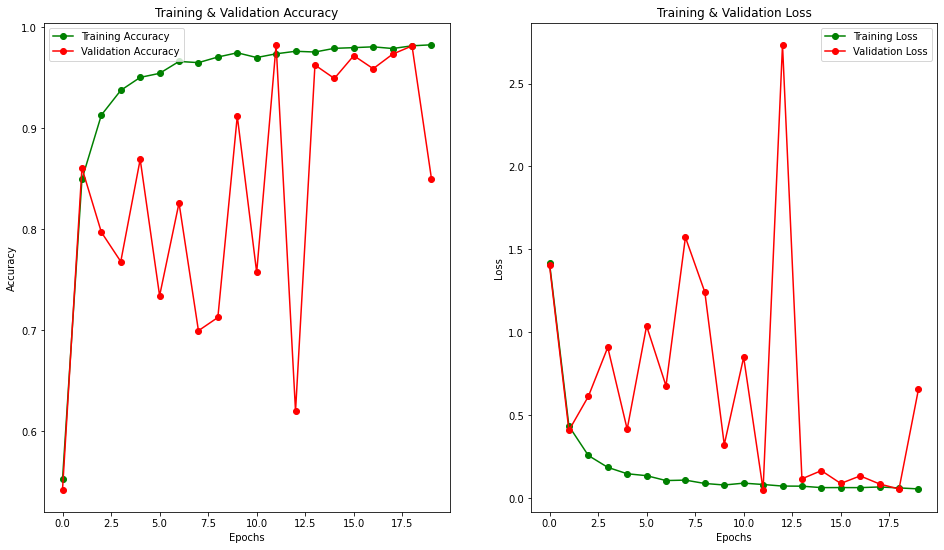

In [24]:
plot_loss_accuracy(history)

In [25]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Kompjuterski vid/Projekat/Projekat_v4/Modeli_v4/model_rgb_aug1.hdf5')

In [26]:
model.evaluate(x_test,y_test)

225/225 [==============================] - 1s 5ms/step - loss: 0.0385 - accuracy: 0.9859 - f1_score: 0.9852 - precision: 0.9862 - recall: 0.9859


[0.03852236643433571,
 0.9859174489974976,
 array([0.93910253, 1.        , 1.        , 0.9601677 , 0.99500495,
        1.        , 0.9470499 , 0.9797753 , 0.93811077, 0.99696964,
        0.9976019 , 0.99489796, 0.99828476, 0.98973304, 1.        ,
        1.        , 0.94117653, 1.        , 1.        , 1.        ,
        0.998557  , 1.        , 0.969147  , 1.        ], dtype=float32),
 0.9861924648284912,
 0.9859174489974976]

In [27]:
x_train/= 255 
model.evaluate(x_train,y_train)

858/858 [==============================] - 4s 4ms/step - loss: 0.0279 - accuracy: 0.9933 - f1_score: 0.9931 - precision: 0.9933 - recall: 0.9932


[0.027907973155379295,
 0.9932981133460999,
 array([0.95788985, 0.9897109 , 1.        , 0.9995821 , 0.99739444,
        1.        , 0.9893371 , 0.97729516, 0.9603306 , 0.99775076,
        0.99919355, 0.9990512 , 0.998695  , 0.998325  , 1.        ,
        1.        , 0.9980643 , 0.9966611 , 0.9912244 , 0.9908735 ,
        0.99494255, 1.        , 1.        , 0.99866015], dtype=float32),
 0.9932976365089417,
 0.9932252764701843]

In [28]:
predict_x= model.predict(x_test) 
predictions=np.argmax(predict_x,axis=1)
print(predictions)

225/225 [==============================] - 1s 2ms/step
[6 5 9 ... 2 4 2]


In [29]:
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1

In [30]:
print(classification_report(y,predictions))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       0.99      0.93      0.96       245
           4       0.99      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      0.90      0.95       348
           7       0.96      1.00      0.98       436
           8       0.88      1.00      0.94       288
          10       1.00      0.99      1.00       331
          11       1.00      1.00      1.00       209
          12       1.00      0.99      0.99       394
          13       1.00      1.00      1.00       291
          14       1.00      0.98      0.99       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       0.89      1.00      0.94       144
          18       1.00    

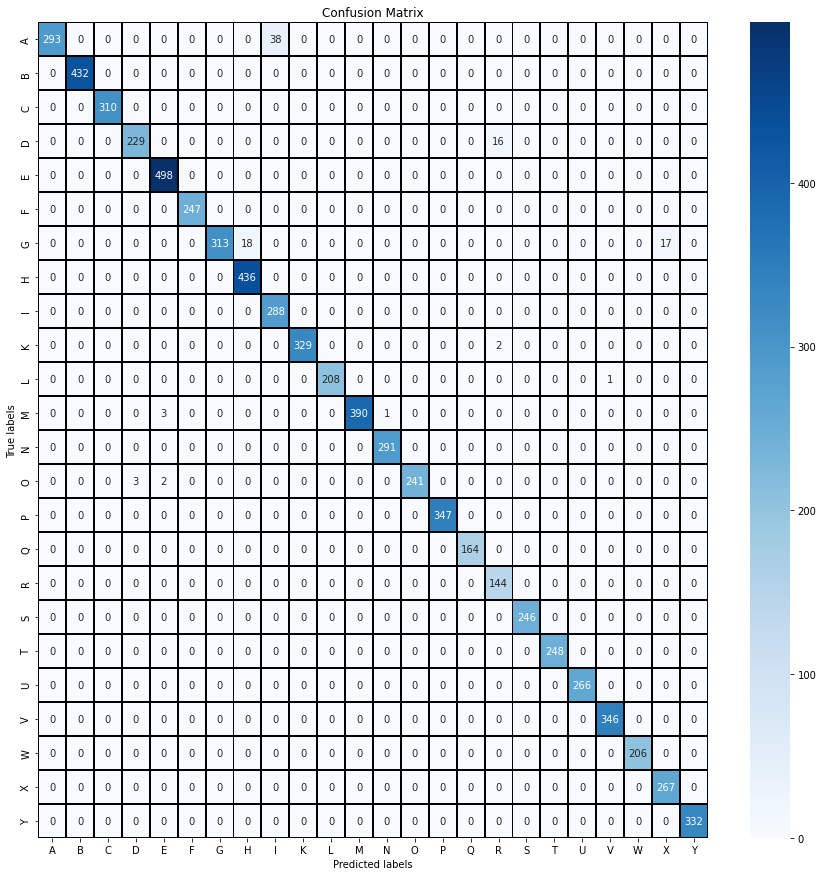

In [31]:
cm = confusion_matrix(y,predictions)
cm = pd.DataFrame(cm, index = [i for i in range(25) if i!=9] , columns = [i for i in range(25) if i!=9])
plt.figure(figsize = (15,15))
ax= plt.subplot()
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labele); ax.yaxis.set_ticklabels(labele);